In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

%matplotlib inline

In [2]:
source_data = pd.read_csv('creditcard.csv')
source_data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [3]:
# 机器学习是按数据大小来界定权重，Amount大重要程度大
# 在这需要对Amount进行数据标准

# 1、StandardScaler就是z-score方法  
# 2、MaxMinScaler就是min_max方法
# https://blog.csdn.net/zbc1090549839/article/details/44103801

In [4]:
from sklearn.preprocessing import StandardScaler 

In [5]:
source_data['New_Amount'] =  StandardScaler().fit_transform(source_data['Amount'].values.reshape(-1,1))
# StandardScaler参数只接受矩阵
data = source_data.drop(columns=['Amount','Time'])

In [6]:
# 检查样本正负label差异
pd.value_counts(source_data['Class'])


0    284315
1       492
Name: Class, dtype: int64

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [10]:
# 数据集中正反lable相差悬殊，需进行重采样
# 重采样常用方法有2种，1、欠采样 代表算法：EasyEnsemble 2、过采样 代表算法：SMOTE

# https://www.cnblogs.com/hithink/p/7360477.html

# 先对数据进行切分
labels = data['Class']
features = data.drop(columns=['Class'])

x_train, x_test, y_train , y_test = train_test_split(features,
                                                    labels,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [11]:
over_sample = SMOTE(random_state=0)
os_x_train , os_y_train = over_sample.fit_sample(x_train ,y_train)

In [12]:
os_x_train = pd.DataFrame(os_x_train)
os_y_train = pd.DataFrame(os_y_train)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report

In [16]:
# 交叉验证准备，切分数据集

def kfold_result_info(x,y,n=5):
    os_x_train = x
    os_x_train = y
    
    kfold = KFold(len(os_y_train),n_folds= n ,shuffle=False,random_state=0)
    for num in range(5):
    #   正则化惩罚项 l2: 
    #   loss = loss + 1/2w² w为明显波动情况，通过过W去判断模型loss值，越低模型效果越好 
    #   正则化惩罚项 l1: 
    #   loss = loss + |w| w为明显波动情况，通过过W去判断模型loss值，越低模型效果越好 
    #   c_param 为参数λ惩罚力度权重，代入不断尝试，构造参数
#     https://www.cnblogs.com/jianxinzhou/p/4083921.html
        c_param = 0.01 * 10 ** num
        print('Regularization L1 Param %s :' %(c_param))
        recall_list = []
        
        for i ,val_idx in enumerate(kfold, start=1):
    #       建立逻辑回归测试模型
            lr = LogisticRegression(C = c_param, penalty='l1')
            lr.fit(os_x_train.iloc[val_idx[0],:], os_y_train.iloc[val_idx[0],:].values.ravel())
            os_pre_result = lr.predict(os_x_train.iloc[val_idx[1],:].values)
            # 模型评估标准 re_call = TP/(TP+NF)
            re_call = recall_score(os_y_train.iloc[val_idx[1],:].values,os_pre_result)
            recall_list.append(re_call)
            
            print('\t Cross-val ReCall_Score: %s' % re_call)
        
        mean_score = np.mean(recall_list)
        print('\nRound%s Mean Score : %s' % (num + 1, mean_score))
        print('\n-----------------------------------------------')

In [13]:
# kfold_result_info(os_x_train,os_y_train)

Regularization L1 Param 0.01 :
	 Cross-val ReCall_Score: 0.9285714285714286
	 Cross-val ReCall_Score: 0.912
	 Cross-val ReCall_Score: 0.9129742033383915
	 Cross-val ReCall_Score: 0.8972703405479417
	 Cross-val ReCall_Score: 0.8974462044795055

Round1 Mean Score : 0.9096524353874536

-----------------------------------------------
Regularization L1 Param 0.1 :
	 Cross-val ReCall_Score: 0.9285714285714286
	 Cross-val ReCall_Score: 0.92
	 Cross-val ReCall_Score: 0.9144410723318159
	 Cross-val ReCall_Score: 0.8986270051628625
	 Cross-val ReCall_Score: 0.8987651839662342

Round2 Mean Score : 0.9120809380064683

-----------------------------------------------
Regularization L1 Param 1.0 :
	 Cross-val ReCall_Score: 0.9285714285714286
	 Cross-val ReCall_Score: 0.92
	 Cross-val ReCall_Score: 0.9146686899342438
	 Cross-val ReCall_Score: 0.8990164181541824
	 Cross-val ReCall_Score: 0.8990792267011695

Round3 Mean Score : 0.9122671526722049

-----------------------------------------------
Regulari

In [17]:
lr = LogisticRegression(C = 100, penalty='l1')
lr.fit(os_x_train, os_y_train.values.ravel())
# os_pre_result = lr.predict(x_test.values)
# model_recall = recall_score(y_test.values,os_pre_result)
# print(model_recall)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
import itertools
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmax = cm.max() / 3.)
    plt.title(title,fontsize = 16)
    plt.colorbar(im,shrink=0.63,pad=0.05) 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0,fontsize = 14)
    plt.yticks(tick_marks, classes,fontsize = 14,rotation=90)

#     fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 fontsize = 16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
#     plt.ylabel('True label',fontsize = 14)
#     plt.xlabel('Predicted label',fontsize = 14)

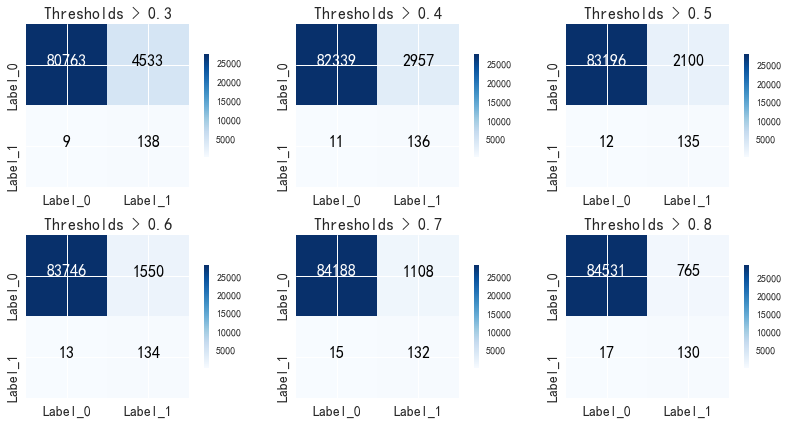

In [24]:
# 模型评估标准 re_call = TP/(TP+NF)
# https://www.jianshu.com/p/28ef55b779ca
plt.figure(figsize=(12,6)) 

for i,t in enumerate(range(3,9),start=1):
    thresholds = t / 10
    y_proba = lr.predict_proba(x_test.values)[:,1] > thresholds
    plt.subplot(2,3,i)
    matrix = confusion_matrix(y_test, y_proba)
    plot_confusion_matrix(matrix, classes=['Label_0','Label_1'],title = 'Thresholds > %s' % thresholds)
#     print(classification_report(y_test, y_proba))

In [46]:
from sklearn.metrics import roc_curve, auc
# y = np.array([1,1,2,2])
# pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(np.array(y_test), lr.predict_proba(x_test.values)[:,1], pos_label=1)
fpr      # array([ 0. ,  0.5,  0.5,  1. ])
tpr      # array([ 0.5,  0.5,  1. ,  1. ])
thresholds      #array([ 0.8 ,  0.4 ,  0.35,  0.1 ])

auc(fpr, tpr)

0.9837992339122856

In [50]:
sns.pointplot(x=fpr.rolling.mean(100), y= tpr.rolling.mean(100))

AttributeError: 'numpy.ndarray' object has no attribute 'rolling'

85443

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [51]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])